In [ ]:
!nvidia-smi

Thu Apr 28 10:19:54 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P8    35W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession

# config = ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 1
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config)

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.8.0


In [ ]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from glob import glob
from time import perf_counter 
import os

In [ ]:
root = 'drive/MyDrive/ml_dataset/final dataset p2'

In [ ]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]
BATCH_SIZE = 64

train_path = root + '/train'
test_path = root + '/test'
validation_path = root + '/val'

In [ ]:
# Import the VGG16 library as shown below and add preprocessing layer to the front of VGG
# Here we will be using imagenet weights

vgg16_base = VGG16(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
vgg16_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
vgg16_head = vgg16_base.output
vgg16_head = Flatten(name="flatten")(vgg16_head)
vgg16_head = Dense(512, activation="relu")(vgg16_head)
vgg16_head = Dropout(0.5)(vgg16_head)
vgg16_head = Dense(2, activation="sigmoid")(vgg16_head)

In [ ]:
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=vgg16_base.input, outputs=vgg16_head)

In [ ]:
# don't train existing weights
for layer in vgg16_base.layers:
    layer.trainable = False

In [ ]:
# useful for getting number of output classes
folders = glob(train_path + '/*')
folders

['drive/MyDrive/ml_dataset/final dataset p2/train/accident',
 'drive/MyDrive/ml_dataset/final dataset p2/train/non accident']

In [ ]:
# view the structure of the model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255)

test_datagen = ImageDataGenerator(rescale = 1./255)
validation_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = BATCH_SIZE,
                                                 class_mode = 'categorical')

Found 8371 images belonging to 2 classes.


In [ ]:
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = BATCH_SIZE,
                                            class_mode = 'categorical')

Found 1049 images belonging to 2 classes.


In [ ]:
# validation_set = test_datagen.flow_from_directory(validation_path,
#                                             target_size = (224, 224),
#                                             batch_size = BATCH_SIZE,
#                                             class_mode = 'categorical')

In [ ]:
# fit the model
# Run the cell. It will take some time to execute
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=30,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/30
131/131 [==============================] - 3035s 23s/step - loss: 0.9889 - accuracy: 0.6311 - val_loss: 0.5851 - val_accuracy: 0.6873
Epoch 2/30
131/131 [==============================] - 84s 643ms/step - loss: 0.5874 - accuracy: 0.6846 - val_loss: 0.5560 - val_accuracy: 0.6969
Epoch 3/30
131/131 [==============================] - 84s 642ms/step - loss: 0.5694 - accuracy: 0.6924 - val_loss: 0.5514 - val_accuracy: 0.6921
Epoch 4/30
131/131 [==============================] - 84s 642ms/step - loss: 0.5559 - accuracy: 0.6962 - val_loss: 0.5276 - val_accuracy: 0.6959
Epoch 5/30
131/131 [==============================] - 84s 642ms/step - loss: 0.5366 - accuracy: 0.7043 - val_loss: 0.5155 - val_accuracy: 0.7054
Epoch 6/30
131/131 [==============================] - 84s 641ms/step - loss: 0.5258 - accuracy: 0.7047 - val_loss: 0.5126 - val_accuracy: 0.7188
Epoch 7/30
131/131 [==============================] - 84s 641ms/step - loss: 0.5328 - accuracy: 0.7034 - val_loss: 0.5055 - val_ac

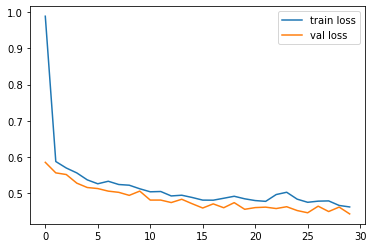

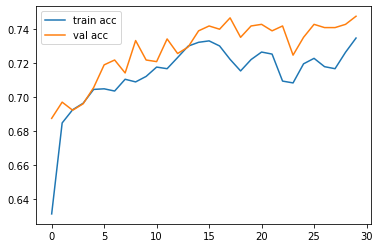

<Figure size 432x288 with 0 Axes>

In [ ]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [ ]:
training_set.reset()
test_set.reset()

In [ ]:
for layer in vgg16_base.layers[15:]:
    layer.trainable = True

In [ ]:
model.compile(
  loss='categorical_crossentropy',
  optimizer=Adam(learning_rate=1e-5),
  metrics=['accuracy']
)

In [ ]:
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=30,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/30
131/131 [==============================] - 95s 709ms/step - loss: 0.4600 - accuracy: 0.7316 - val_loss: 0.4454 - val_accuracy: 0.7455
Epoch 2/30
131/131 [==============================] - 92s 701ms/step - loss: 0.4418 - accuracy: 0.7405 - val_loss: 0.4442 - val_accuracy: 0.7445
Epoch 3/30
131/131 [==============================] - 92s 702ms/step - loss: 0.4327 - accuracy: 0.7466 - val_loss: 0.4302 - val_accuracy: 0.7579
Epoch 4/30
131/131 [==============================] - 92s 701ms/step - loss: 0.4282 - accuracy: 0.7466 - val_loss: 0.4272 - val_accuracy: 0.7569
Epoch 5/30
131/131 [==============================] - 92s 702ms/step - loss: 0.4213 - accuracy: 0.7452 - val_loss: 0.4248 - val_accuracy: 0.7502
Epoch 6/30
131/131 [==============================] - 92s 702ms/step - loss: 0.4208 - accuracy: 0.7478 - val_loss: 0.4320 - val_accuracy: 0.7560
Epoch 7/30
131/131 [==============================] - 92s 701ms/step - loss: 0.4134 - accuracy: 0.7508 - val_loss: 0.4199 - val_ac

In [ ]:
from tensorflow.keras.models import load_model

model.save('model_vgg16_6.h5')

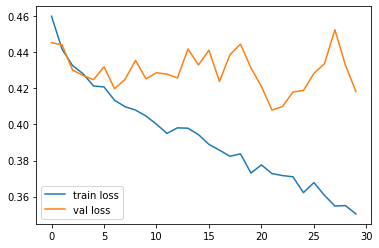

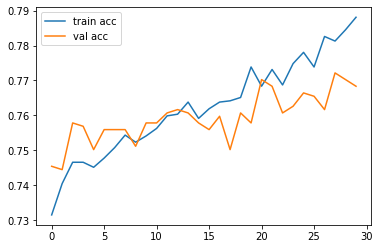

<Figure size 432x288 with 0 Axes>

In [ ]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

Found 1049 files belonging to 2 classes.


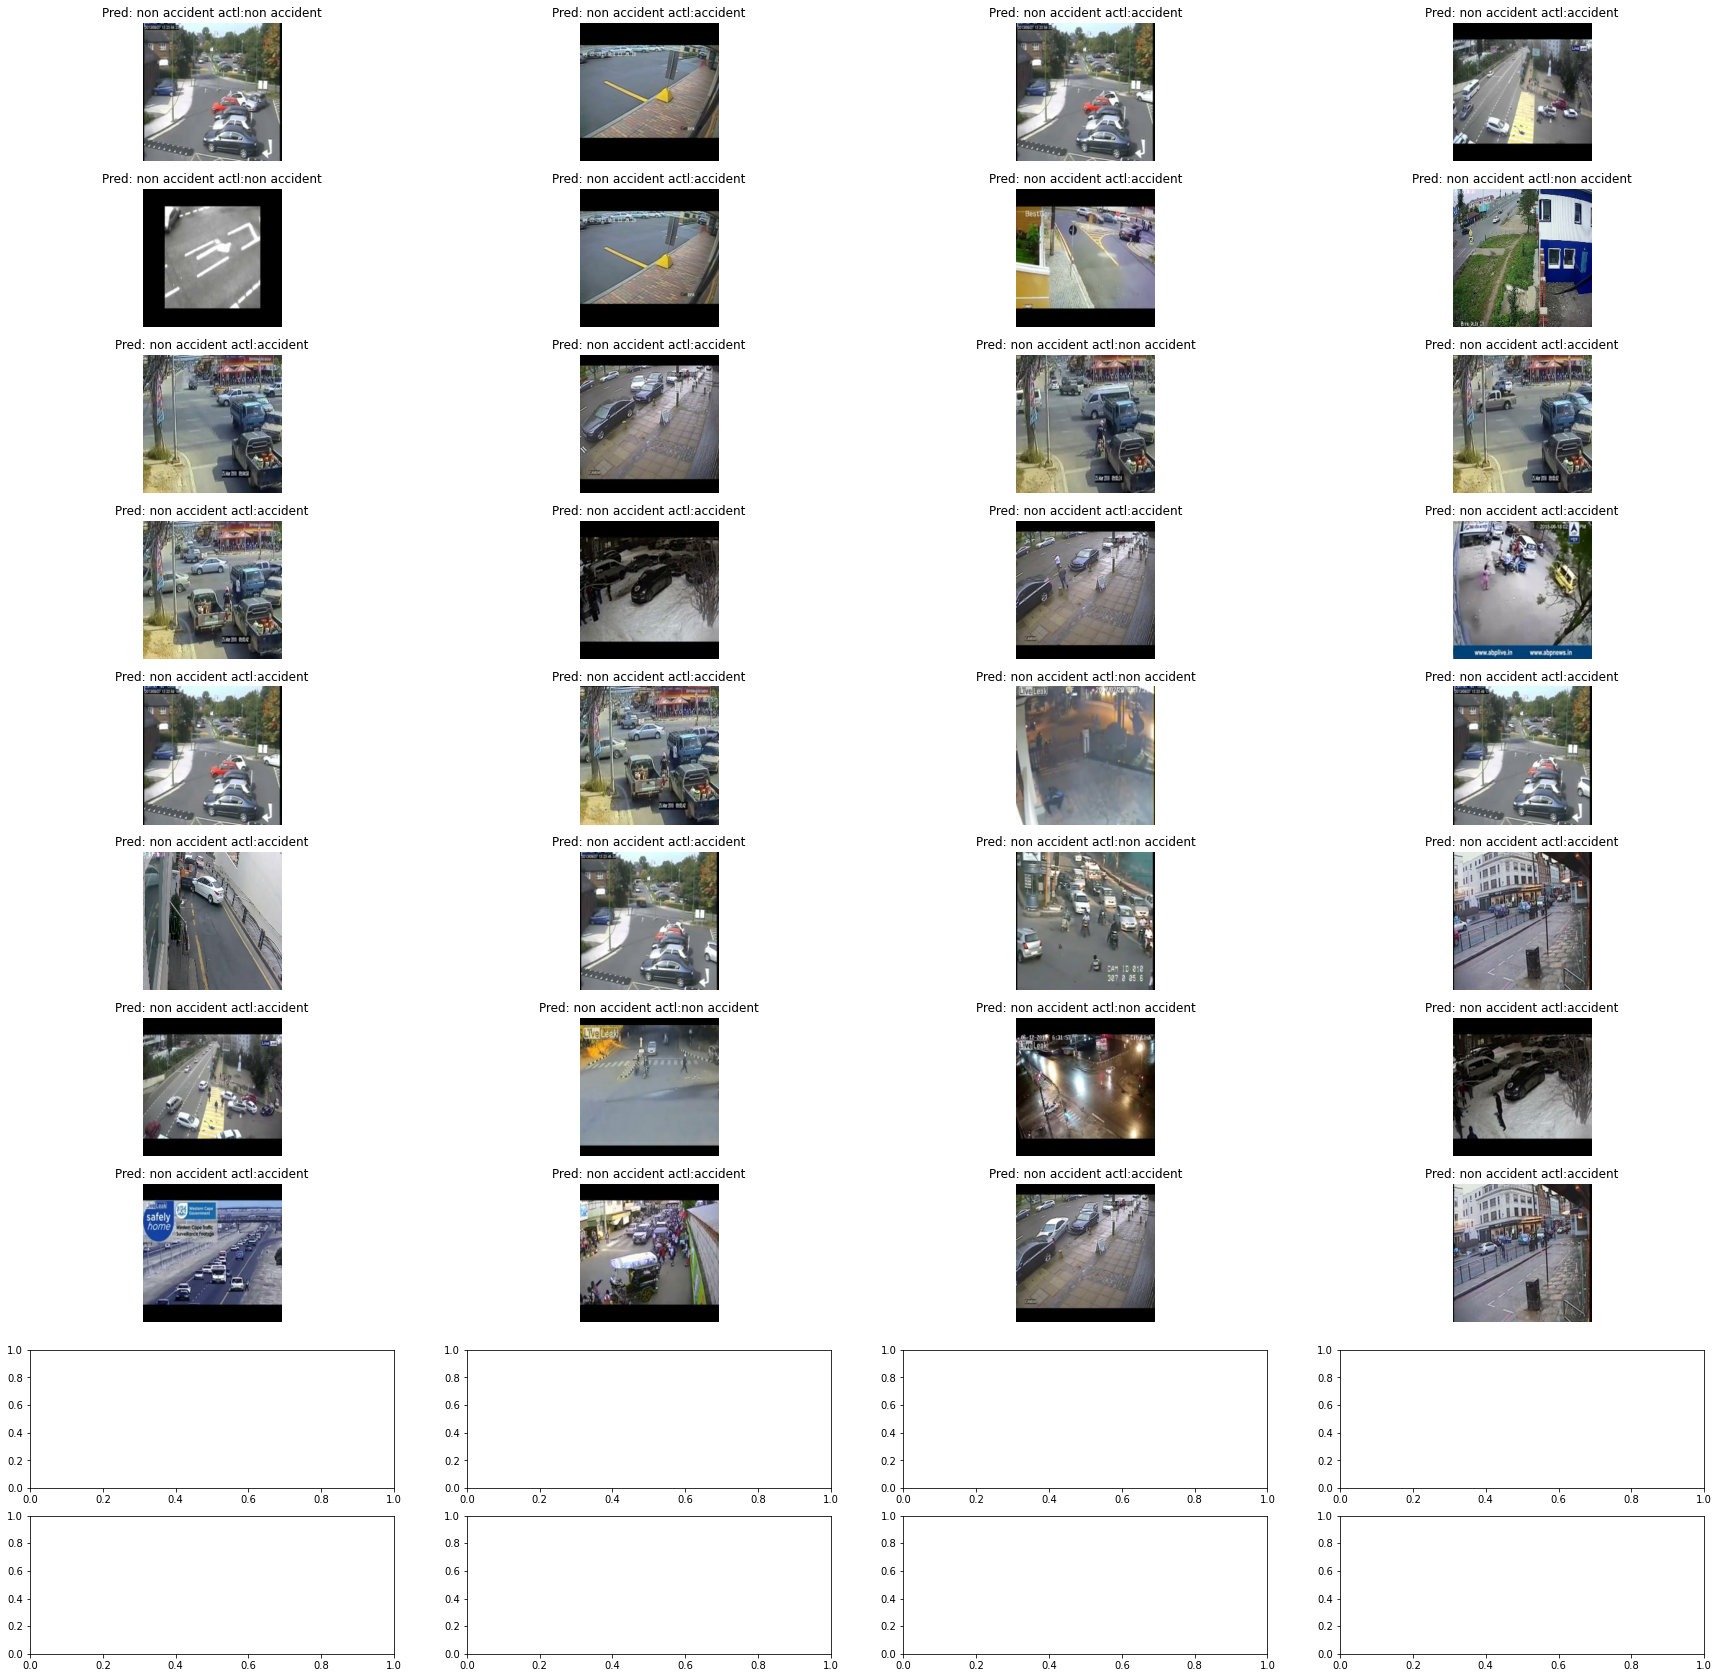

In [ ]:
testing_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    seed=42,
    image_size= IMAGE_SIZE)

class_names = testing_ds.class_names

## lets vizualize results on testing data
AccuracyVector = []
plt.figure(figsize=(30, 30))
for images, labels in testing_ds.take(1):
    predictions = model.predict(images)
    predlabel = []
    prdlbl = []
    
    for mem in predictions:
        predlabel.append(class_names[np.argmax(mem)])
        prdlbl.append(np.argmax(mem))
    
    AccuracyVector = np.array(prdlbl) == labels
    for i in range(40):
        ax = plt.subplot(10, 4, i + 1)
        #plt.imshow(images[i].numpy().astype("uint8"))
        try:
          plt.imshow(images[i].numpy().astype("uint8"))
        except:
          continue
        plt.title('Pred: '+ predlabel[i]+' actl:'+class_names[labels[i]] )
        plt.axis('off')
        plt.grid(True)